In [16]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForSeq2Seq
import torch
from torch.utils.data import Dataset
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datasets import load_dataset

dataset = load_dataset("/kaggle/input/conll003-englishversion")
def read_conll_file(filepath):
    sentences = []
    tags = []
    with open(filepath, 'r') as file:
        tokens = []
        labels = []
        for line in file:
            line = line.strip()
            if not line:
                if tokens:
                    sentences.append(tokens)
                    tags.append(labels)
                    tokens, labels = [], []
            else:
                splits = line.split()
                tokens.append(splits[0])
                labels.append(splits[-1])
        if tokens:
            sentences.append(tokens)
            tags.append(labels)
    return sentences, tags

train_sentences, train_labels = read_conll_file("/kaggle/input/conll003-englishversion/train.txt")
val_sentences, val_labels = read_conll_file("/kaggle/input/conll003-englishversion/valid.txt")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [17]:
def convert_for_t5(sentences, labels):
    data = []
    for tokens, tags in zip(sentences, labels):
        text = " ".join(tokens)
        entities = []
        current_entity = []
        current_type = None
        for token, tag in zip(tokens, tags):
            if tag.startswith("B-"):
                if current_entity:
                    entities.append(f"{current_type}: {' '.join(current_entity)}")
                current_type = tag[2:]
                current_entity = [token]
            elif tag.startswith("I-") and current_entity:
                current_entity.append(token)
            else:
                if current_entity:
                    entities.append(f"{current_type}: {' '.join(current_entity)}")
                current_entity = []
                current_type = None
        if current_entity:
            entities.append(f"{current_type}: {' '.join(current_entity)}")

        data.append({
            "input_text": f"extract entities: {text}",
            "target_text": "; ".join(entities) if entities else "None"
        })
    return data

train_data = convert_for_t5(train_sentences, train_labels)
val_data = convert_for_t5(val_sentences, val_labels)

In [18]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")

def tokenize_data(data):
    inputs = tokenizer([x["input_text"] for x in data], padding=True, truncation=True, max_length=128, return_tensors="pt")
    targets = tokenizer([x["target_text"] for x in data], padding=True, truncation=True, max_length=64, return_tensors="pt")
    return {
        "input_ids": inputs.input_ids,
        "attention_mask": inputs.attention_mask,
        "labels": targets.input_ids
    }

train_dataset = tokenize_data(train_data)
val_dataset = tokenize_data(val_data)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pip install transformers --upgrade

In [32]:

class NERDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.encodings.items()}
    def __len__(self):
        return len(self.encodings["input_ids"])

train_ds = NERDataset(train_dataset)
val_ds = NERDataset(val_dataset)

model = T5ForConditionalGeneration.from_pretrained("t5-small")

from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="./ner_t5_model",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,  # ✅ Loads the best model
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # ✅ Stops if no improvement in 2 evals
)

trainer.train()


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.058700,0.038638
2,0.029100,0.019698
3,0.013500,0.015985
4,0.019800,0.014236
5,0.015000,0.013842
6,0.011200,0.013108
7,0.013800,0.012911
8,0.012500,0.012791
9,0.010900,0.012547
10,0.009100,0.012565


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=9370, training_loss=0.05118676002357024, metrics={'train_runtime': 1795.2103, 'train_samples_per_second': 83.483, 'train_steps_per_second': 5.219, 'total_flos': 5070918946652160.0, 'train_loss': 0.05118676002357024, 'epoch': 10.0})

In [33]:
def generate_predictions(texts):
    model.eval()
    results = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to("cuda")
        outputs = model.generate(inputs["input_ids"], max_length=64)
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        results.append(decoded)
    return results

sample_inputs = [d["input_text"] for d in val_data[:5]]
preds = generate_predictions(sample_inputs)

for inp, pred in zip(sample_inputs, preds):
    print(f" {inp}")
    print(f" Prediction: {pred}\n")

 extract entities: -DOCSTART-
 Prediction: None

 extract entities: CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTER INNINGS VICTORY .
 Prediction: PER: LEICESTERSHIRE

 extract entities: LONDON 1996-08-30
 Prediction: LOC: LONDON

 extract entities: West Indian all-rounder Phil Simmons took four for 38 on Friday as Leicestershire beat Somerset by an innings and 39 runs in two days to take over at the head of the county championship .
 Prediction: MISC: West Indian; PER: Phil Simmons; ORG: Leicestershire; ORG: Somerset

 extract entities: Their stay on top , though , may be short-lived as title rivals Essex , Derbyshire and Surrey all closed in on victory while Kent made up for lost time in their rain-affected match against Nottinghamshire .
 Prediction: ORG: Essex; ORG: Derbyshire; ORG: Surrey; ORG: Kent; ORG: Nottinghamshire



In [34]:
def generate_predictions(inputs):
    model.eval()
    results = []
    for inp in inputs:
        inputs = tokenizer(inp, return_tensors="pt", truncation=True).to(model.device)
        outputs = model.generate(**inputs, max_length=64)
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        results.append(decoded)
    return results

def extract_entities(text):
    entities = []
    if text and text != "None":
        parts = text.split(";")
        for part in parts:
            if ":" in part:
                tag, phrase = part.strip().split(":", 1)
                phrase = phrase.strip()
                for word in phrase.split():
                    entities.append((word, tag.strip()))
    return entities

y_true = []
y_pred = []


for d in val_data[:150]:  
    input_text = d["input_text"]
    target_text = d["target_text"]
    
    pred_text = generate_predictions([input_text])[0]
    
    true_entities = extract_entities(target_text)
    pred_entities = extract_entities(pred_text)
    
    true_labels = [label for _, label in true_entities]
    pred_labels = [label for _, label in pred_entities]
    
    min_len = min(len(true_labels), len(pred_labels))
    y_true.extend(true_labels[:min_len])
    y_pred.extend(pred_labels[:min_len])

print("\n Evaluation Report for T5 NER:")
print(classification_report(y_true, y_pred, digits=3))


 Evaluation Report for T5 NER:
              precision    recall  f1-score   support

         LOC      0.907     0.897     0.902        87
        MISC      0.766     0.947     0.847        38
         ORG      0.912     0.769     0.834       108
         PER      0.934     0.993     0.962       142

    accuracy                          0.901       375
   macro avg      0.880     0.901     0.886       375
weighted avg      0.904     0.901     0.900       375



<Figure size 800x600 with 0 Axes>

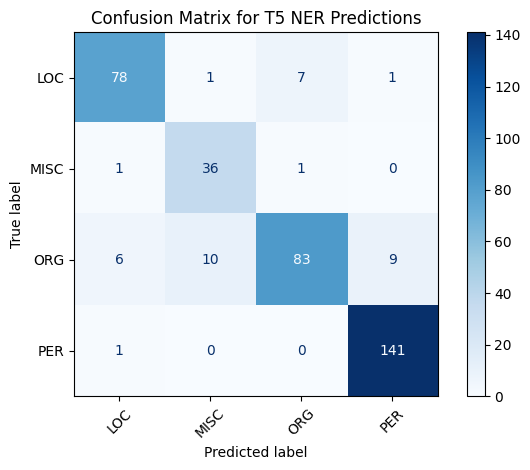

In [35]:
labels = sorted(set(y_true + y_pred)) 

cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
plt.title("Confusion Matrix for T5 NER Predictions")
plt.tight_layout()
plt.show()